In [32]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import numpy as np
# import the necessary packages

In [33]:
folder = "store-sales-time-series-forecasting"

train_df = pd.read_csv(f"{folder}/train.csv")
test_df = pd.read_csv(f"{folder}/test.csv")
stores_df = pd.read_csv(f"{folder}/stores.csv")
oil_df = pd.read_csv(f"{folder}/oil.csv")
holidays_df = pd.read_csv(f"{folder}/holidays_events.csv")
transactions_df = pd.read_csv(f"{folder}/transactions.csv")

In [34]:
train_df['date'] = pd.to_datetime(train_df['date']) 
test_df['date'] = pd.to_datetime(test_df['date'])
oil_df['date'] = pd.to_datetime(oil_df['date'])
holidays_df['date'] = pd.to_datetime(holidays_df['date'])
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

# convert date str to datetime

In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [36]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [37]:
train_df['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [38]:
unique_date_sales = train_df.groupby("date")["sales"].sum().reset_index()
unique_date_promotions = train_df.groupby("date")["onpromotion"].sum().reset_index()

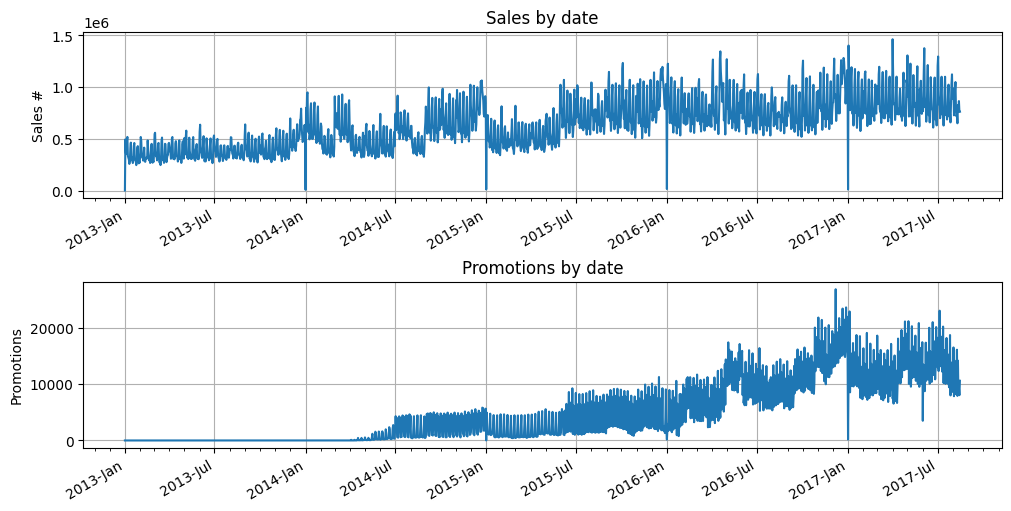

In [39]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5), layout='constrained')
axs[0].plot('date', 'sales', data=unique_date_sales)
axs[0].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
axs[0].xaxis.set_minor_locator(mdates.MonthLocator())
axs[0].grid(True)
axs[0].set_ylabel(r'Sales #')
axs[0].set_title("Sales by date")
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

axs[1].plot('date', 'onpromotion', data=unique_date_promotions)
axs[1].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
axs[1].xaxis.set_minor_locator(mdates.MonthLocator())
axs[1].grid(True)
axs[1].set_ylabel(r'Promotions')
axs[1].set_title("Promotions by date")
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

for ax in axs:
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')

In [40]:
store_sales = train_df.groupby("store_nbr")["sales"].sum().reset_index()
store_promotions = train_df.groupby("store_nbr")["onpromotion"].sum().reset_index()

Text(0.5, 0, 'Store Number #')

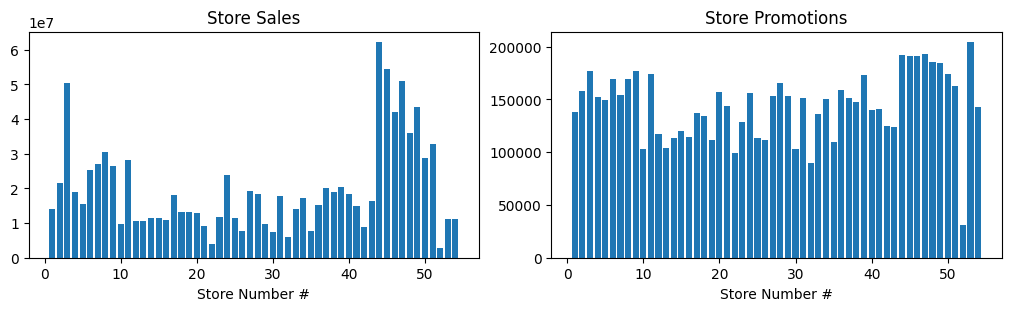

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), layout='constrained')
ax[0].bar("store_nbr", "sales", data=store_sales)
ax[1].bar("store_nbr", "onpromotion", data=store_promotions)
ax[0].set_title("Store Sales")
ax[1].set_title("Store Promotions")
ax[0].set_xlabel("Store Number #")
ax[1].set_xlabel("Store Number #")

In [42]:
family_sales = train_df.groupby("family")["sales"].sum().reset_index()
family_promotions = train_df.groupby("family")["onpromotion"].sum().reset_index()

Text(0.5, 1.0, 'Category Family Sales')

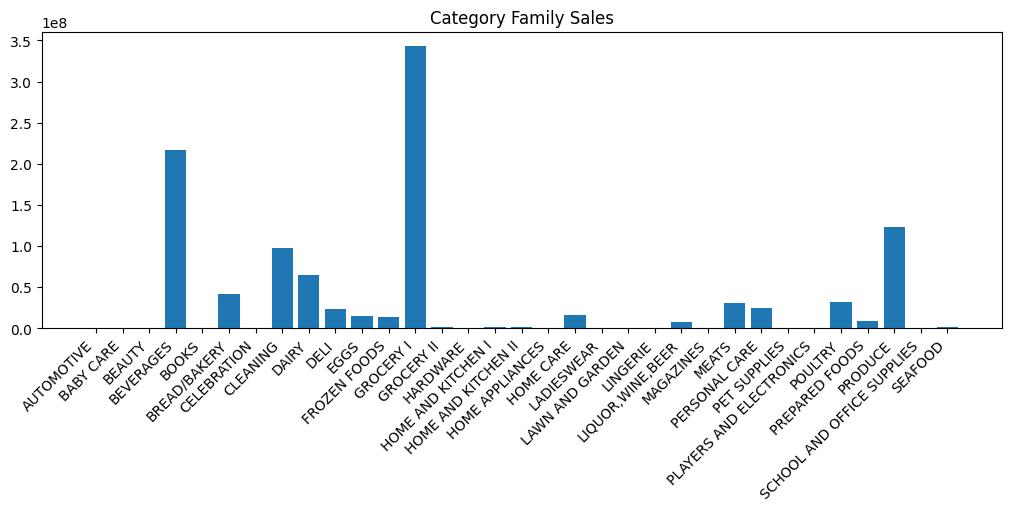

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), layout='constrained')
ax.bar("family", "sales", data=family_sales)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title("Category Family Sales")

Text(0.5, 0, 'Store Number #')

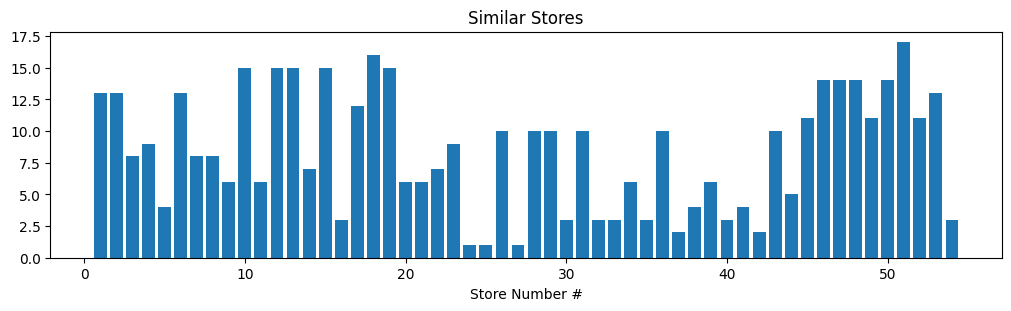

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3), layout='constrained')
ax.bar("store_nbr", "cluster", data=stores_df)
ax.set_title("Similar Stores")
ax.set_xlabel("Store Number #")

In [45]:
data_df = pd.DataFrame(train_df)
data_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


Now make the table nicer

In [46]:
oil_df = oil_df.rename(columns={"dcoilwtico": "oil_price"})

data_df = pd.merge_ordered(data_df, oil_df, on='date', fill_method='ffill', how='left') # merge oil price with corresponding date
data_df['oil_price'] = data_df['oil_price'].bfill() # use bfill to replace first date with the next date's oil price
data_df.head()

,id,date,store_nbr,family,sales,onpromotion,oil_price
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,93.14


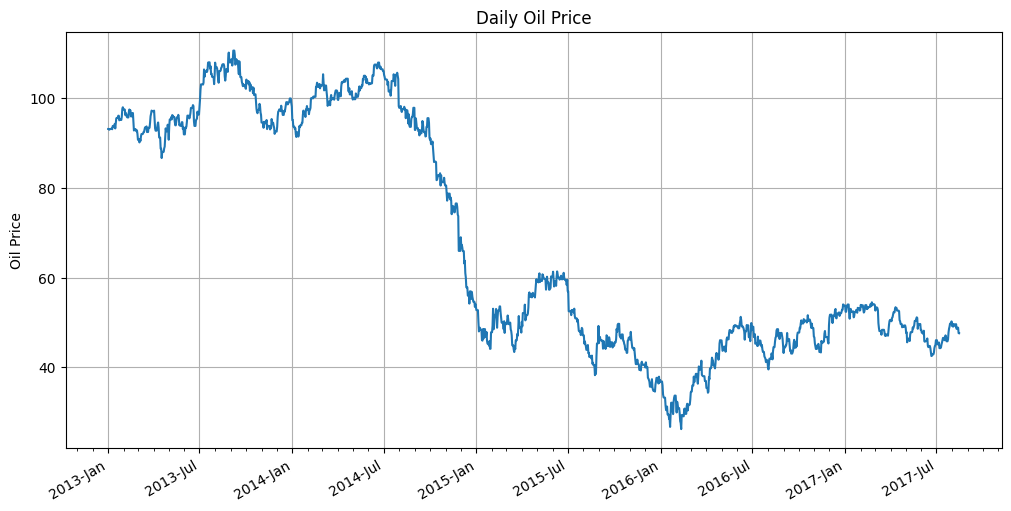

In [47]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5), layout='constrained')
axs.plot('date', 'oil_price', data=data_df)
axs.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
axs.xaxis.set_minor_locator(mdates.MonthLocator())
axs.grid(True)
axs.set_ylabel('Oil Price')
axs.set_title('Daily Oil Price')
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

for label in axs.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

In [48]:
data_df = pd.merge_ordered(data_df, stores_df, on='store_nbr', how='left')
data_df = data_df.drop(['city', 'state', 'type'], axis=1) # merge only cluster value from stores dataframe

data_df.head()

,id,date,store_nbr,family,sales,onpromotion,oil_price,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,13
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,13
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,13
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,13


In [49]:
holidays_df = holidays_df[holidays_df.transferred == False] # remove transfers as they're not true holidays

holidays_df['holiday'] = True
holidays_df['holiday'] = holidays_df['holiday'].astype(bool)
data_df = pd.merge(data_df, holidays_df, on='date', how='left') 
data_df['holiday'] = data_df['holiday'].fillna(False) # set all dates from the specific holiday to true and false otherwise

data_df = data_df.drop(['type', 'locale', 'locale_name', 'description', 'transferred'], axis=1) # drop other columns from holidays

data_df.head()

C:\Users\abhin\AppData\Local\Temp\ipykernel_7584\3549927836.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_df['holiday'] = data_df['holiday'].fillna(False) # set all dates from the specific holiday to true and false otherwise


,id,date,store_nbr,family,sales,onpromotion,oil_price,cluster,holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,13,True
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,13,True
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,13,True
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,13,True
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,13,True


In [50]:
data_df['wage_day'] = data_df['date'].dt.is_month_end | (data_df['date'].dt.day == 15) # set 15th day of month and last day of month as wage_day
data_df.head()

,id,date,store_nbr,family,sales,onpromotion,oil_price,cluster,holiday,wage_day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,13,True,False
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,13,True,False
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,13,True,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,13,True,False
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,13,True,False


Earthquake

In [51]:
data_df['recent_earthquake'] = data_df['date'] > np.datetime64('2016-04-16') # set all dates past the earthquake to true
data_df.head()

,id,date,store_nbr,family,sales,onpromotion,oil_price,cluster,holiday,wage_day,recent_earthquake
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,13,True,False,False
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,13,True,False,False
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,13,True,False,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,13,True,False,False
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,13,True,False,False


In [52]:
data_df['day'] = data_df['date'].dt.day
data_df['month'] = data_df['date'].dt.month
data_df['year'] = data_df['date'].dt.year

data_df['timestamp'] = data_df['date'].astype('int64') # add timestamp to help model

data_df = data_df.drop(['id', 'date'], axis=1)
data_df.head()

,store_nbr,family,sales,onpromotion,oil_price,cluster,holiday,wage_day,recent_earthquake,day,month,year,timestamp
0,1,AUTOMOTIVE,0.0,0,93.14,13,True,False,False,1,1,2013,1356998400000000000
1,1,BABY CARE,0.0,0,93.14,13,True,False,False,1,1,2013,1356998400000000000
2,1,BEAUTY,0.0,0,93.14,13,True,False,False,1,1,2013,1356998400000000000
3,1,BEVERAGES,0.0,0,93.14,13,True,False,False,1,1,2013,1356998400000000000
4,1,BOOKS,0.0,0,93.14,13,True,False,False,1,1,2013,1356998400000000000


In [53]:
le = LabelEncoder()
data_df['family'] = le.fit_transform(data_df.family.values) # label encode the family categories

data_df.head()

,store_nbr,family,sales,onpromotion,oil_price,cluster,holiday,wage_day,recent_earthquake,day,month,year,timestamp
0,1,0,0.0,0,93.14,13,True,False,False,1,1,2013,1356998400000000000
1,1,1,0.0,0,93.14,13,True,False,False,1,1,2013,1356998400000000000
2,1,2,0.0,0,93.14,13,True,False,False,1,1,2013,1356998400000000000
3,1,3,0.0,0,93.14,13,True,False,False,1,1,2013,1356998400000000000
4,1,4,0.0,0,93.14,13,True,False,False,1,1,2013,1356998400000000000


In [54]:
data_df['store_nbr'] = data_df['store_nbr'].astype('category')
data_df['family'] = data_df['family'].astype('category')

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 13 columns):
 #   Column             Dtype   
---  ------             -----   
 0   store_nbr          category
 1   family             category
 2   sales              float64 
 3   onpromotion        int64   
 4   oil_price          float64 
 5   cluster            int64   
 6   holiday            bool    
 7   wage_day           bool    
 8   recent_earthquake  bool    
 9   day                int32   
 10  month              int32   
 11  year               int32   
 12  timestamp          int64   
dtypes: bool(3), category(2), float64(2), int32(3), int64(3)
memory usage: 166.0 MB


In [55]:
X = data_df.drop('sales', axis=1)  # features without the label
y = data_df['sales']  # The target Label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # split data

55.1845753356916

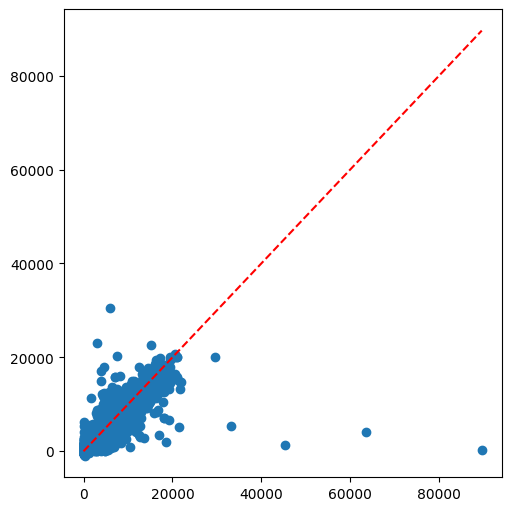

In [56]:
model = XGBRegressor(enable_categorical=True, max_depth=12)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

fig,ax = plt.subplots(1, 1, figsize=(5, 5),layout='constrained')
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', markersize=10)  # 45-degree line

error = mean_absolute_error(y_test, y_pred)
error

Run the new model on the actual test samples

In [57]:
data_df = pd.DataFrame(test_df) # new test dataframe

data_df = pd.merge_ordered(data_df, oil_df, on='date', fill_method='ffill', how='left') 
data_df['oil_price'] = data_df['oil_price'].bfill()

data_df = pd.merge_ordered(data_df, stores_df, on='store_nbr', how='left')
data_df = data_df.drop(['city', 'state', 'type'], axis=1)

data_df = pd.merge(data_df, holidays_df, on='date', how='left')
data_df['holiday'] = data_df['holiday'].fillna(False)

data_df = data_df.drop(['type', 'locale', 'locale_name', 'description', 'transferred'], axis=1)

data_df['wage_day'] = data_df['date'].dt.is_month_end | (data_df['date'].dt.day == 15)
data_df['recent_earthquake'] = data_df['date'] > np.datetime64('2016-04-16')

data_df['day'] = data_df['date'].dt.day
data_df['month'] = data_df['date'].dt.month
data_df['year'] = data_df['date'].dt.year

data_df['timestamp'] = data_df['date'].astype('int64') 

data_df = data_df.drop(['id', 'date'], axis=1)

le = LabelEncoder()
data_df['family'] = le.fit_transform(data_df.family.values)

data_df['store_nbr'] = data_df['store_nbr'].astype('category')
data_df['family'] = data_df['family'].astype('category')

# do the same data processing procedure on the testing set
data_df.head()

C:\Users\abhin\AppData\Local\Temp\ipykernel_7584\3175470123.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_df['holiday'] = data_df['holiday'].fillna(False)


,store_nbr,family,onpromotion,oil_price,cluster,holiday,wage_day,recent_earthquake,day,month,year,timestamp
0,1,0,0,46.8,13,False,False,True,16,8,2017,1502841600000000000
1,1,1,0,46.8,13,False,False,True,16,8,2017,1502841600000000000
2,1,2,2,46.8,13,False,False,True,16,8,2017,1502841600000000000
3,1,3,20,46.8,13,False,False,True,16,8,2017,1502841600000000000
4,1,4,0,46.8,13,False,False,True,16,8,2017,1502841600000000000


In [58]:
y_pred_test = model.predict(data_df)

In [59]:
test_submission = test_df[['id']].copy()
test_submission['sales'] = y_pred_test
test_submission['sales'] = test_submission['sales'].clip(lower=0)
test_submission.head()

,id,sales
0,3000888,1.572692
1,3000889,0.000000
2,3000890,4.824606
3,3000891,1670.616699
4,3000892,0.000000


In [60]:
test_submission.to_csv("submission.csv", index=False)